In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [15]:
import sys
sys.path.append('../code')
from importlib import reload  
import lib_LinearAlgebra
import lib_cnnPTRS, util_misc
lib_LinearAlgebra = reload(lib_LinearAlgebra)
lib_cnnPTRS = reload(lib_cnnPTRS)
util_misc = reload(util_misc)

# Simulate data

In [16]:
def inter_term(x, beta, i, j):
    return x[:, i, np.newaxis] * x[:, j, np.newaxis] @ beta

In [17]:
n = 1000
k = 30
n_outcome = 4
kcovar = 20
beta = np.reshape(np.array(range(1, k * n_outcome + 1)), newshape = [k, n_outcome])
bcovar = np.reshape(np.array(range(1, kcovar * n_outcome + 1)), newshape = [kcovar, n_outcome]) * 0.2
intercepts = np.array([230, 250, 270, 290])

x = np.random.normal(size = [n, k])
covar = np.random.normal(size = [n, kcovar])
y = np.matmul(x, beta) + np.matmul(covar, bcovar) + np.random.normal(size = [n, n_outcome]) + intercepts + inter_term(x, beta[np.newaxis, 10, :] * 10, 0, 1) + inter_term(x, beta[np.newaxis, 5, :] * 10, 2, 3) + inter_term(x, beta[np.newaxis, 7, :] * 10, 0, 2) + inter_term(x, beta[np.newaxis, 5, :] * 10, 1, 3) + inter_term(x, beta[np.newaxis, 9, :] * 10, 0, 3) + inter_term(x, beta[np.newaxis, 12, :] * 10, 1, 2)
dataset = tf.data.Dataset.from_tensor_slices((x, np.concatenate((y, covar), axis = 1)))
dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.cast(y, tf.float32)))
dataset = dataset.batch(7)
tempx = np.concatenate((x, covar), axis = 1)
tempx = tempx[:, :, np.newaxis]
tempy = y[:, 0, np.newaxis]


# Preparing datasets

In [18]:
def get_inputs_and_y(dataset, n_outcome, block = 100000000):
    for inputs, y in dataset.unbatch().batch(block):
#         inputs = [inputs, y[:, n_outcome:]]
#         y = y[:, :n_outcome]
        break
    return inputs, y

# data splitting 
dataset_train = dataset.take(100)
dataset_valid = dataset.skip(100).take(15)
dataset_test = dataset.skip(115).take(100)

ele_valid = get_inputs_and_y(dataset_valid, n_outcome)
ele_test = get_inputs_and_y(dataset_test, n_outcome)

In [19]:
ele_valid[0][0].shape

TensorShape([30])

# Run least squares

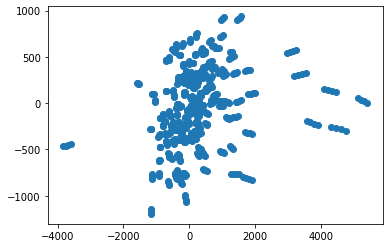

In [20]:
data_scheme = lib_LinearAlgebra.DataScheme(
    dataset = dataset_train, 
    X_index = 0, 
    Y_index = 1, 
    outcome_indice = [ 0, 1, 2, 3 ], 
    covariate_indice = np.array([ i for i in range(n_outcome, kcovar + n_outcome) ])
)

solver = lib_LinearAlgebra.LeastSquaredEstimator(data_scheme, normalizer = False, intercept = True)

solver.solve()

o = solver.predict_x(dataset_test) 
ytest_ls = o['y']
ytest_pred_ls = o['y_pred_from_x']
plt.scatter(ytest_ls, ytest_pred_ls)

# Try `cnnPTRS`

In [21]:
cnn_model = util_misc.load_ordered_yaml('../misc_files/cnn_test.yaml')

cnn = lib_cnnPTRS.cnnPTRS(cnn_model, data_scheme, normalizer = True)

cnn.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 30, 1)]      0                                            
__________________________________________________________________________________________________
layer1_conv (Conv1D)            (None, 27, 32)       160         input_3[0][0]                    
__________________________________________________________________________________________________
layer1_maxpool (MaxPooling1D)   (None, 13, 32)       0           layer1_conv[0][0]                
__________________________________________________________________________________________________
layer1_dropout (Dropout)        (None, 13, 32)       0           layer1_maxpool[0][0]             
____________________________________________________________________________________________

In [22]:
# ele_valid[0].shape

In [23]:
optimizer = tf.keras.optimizers.Adam()
norm, norm_v = cnn.prep_train(ele_valid) 
mytrain = cnn.train_func()
mytrain(cnn, optimizer, 200, ele_valid, norm, norm_v)

Step 10 : loss 1073478.88 ; validation-accuracy: 0.000104667619
Step 20 : loss 568179 ; validation-accuracy: 0.00528853387
Step 30 : loss 1749598.12 ; validation-accuracy: 0.0117232986
Step 40 : loss 525214.375 ; validation-accuracy: 0.0218533128
Step 50 : loss 5366067 ; validation-accuracy: 0.0368835628
Step 60 : loss 423507.562 ; validation-accuracy: 0.0539066792
Step 70 : loss 529563.375 ; validation-accuracy: 0.0660188049
Step 80 : loss 761312.875 ; validation-accuracy: 0.0746908411
Step 90 : loss 246884.109 ; validation-accuracy: 0.094914645
Step 100 : loss 1240974.88 ; validation-accuracy: 0.124967664
Step 110 : loss 1059421.12 ; validation-accuracy: 0.159108579
Step 120 : loss 577295.625 ; validation-accuracy: 0.175422966
Step 130 : loss 1.74343e+06 ; validation-accuracy: 0.186632484
Step 140 : loss 532796.125 ; validation-accuracy: 0.195880562
Step 150 : loss 5276712.5 ; validation-accuracy: 0.206380278
Step 160 : loss 414089.062 ; validation-accuracy: 0.215430945
Step 170 : lo

Step 1340 : loss 611419.312 ; validation-accuracy: 0.351629019
Step 1350 : loss 3828804.25 ; validation-accuracy: 0.352272034
Step 1360 : loss 348385.438 ; validation-accuracy: 0.353493601
Step 1370 : loss 530352.188 ; validation-accuracy: 0.354655296
Step 1380 : loss 565214.062 ; validation-accuracy: 0.355917454
Step 1390 : loss 270156.156 ; validation-accuracy: 0.35620454
Step 1400 : loss 889709.875 ; validation-accuracy: 0.355276257
Step 1410 : loss 739379.875 ; validation-accuracy: 0.353894919
Step 1420 : loss 431525.719 ; validation-accuracy: 0.352937609
Step 1430 : loss 1308285.12 ; validation-accuracy: 0.352692366
Step 1440 : loss 611257.125 ; validation-accuracy: 0.352784932
Step 1450 : loss 3901621.75 ; validation-accuracy: 0.353411943
Step 1460 : loss 346059.312 ; validation-accuracy: 0.354543954
Step 1470 : loss 519676.344 ; validation-accuracy: 0.355661422
Step 1480 : loss 603381.062 ; validation-accuracy: 0.356808096
Step 1490 : loss 243567.109 ; validation-accuracy: 0.356

Step 2660 : loss 344223.406 ; validation-accuracy: 0.368830025
Step 2670 : loss 506573 ; validation-accuracy: 0.369145095
Step 2680 : loss 581911.25 ; validation-accuracy: 0.369434118
Step 2690 : loss 236274.891 ; validation-accuracy: 0.369335771
Step 2700 : loss 817357.125 ; validation-accuracy: 0.36878413
Step 2710 : loss 673917.562 ; validation-accuracy: 0.367936075
Step 2720 : loss 355244.562 ; validation-accuracy: 0.367309868
Step 2730 : loss 1139570.38 ; validation-accuracy: 0.367706329
Step 2740 : loss 611202.812 ; validation-accuracy: 0.368401527
Step 2750 : loss 3051491.25 ; validation-accuracy: 0.369123399
Step 2760 : loss 364768.656 ; validation-accuracy: 0.369749904
Step 2770 : loss 397653.562 ; validation-accuracy: 0.3701424
Step 2780 : loss 644029.438 ; validation-accuracy: 0.370370805
Step 2790 : loss 224303.484 ; validation-accuracy: 0.370408
Step 2800 : loss 880207.188 ; validation-accuracy: 0.369861901
Step 2810 : loss 674016.5 ; validation-accuracy: 0.368929625
Step 

Step 3980 : loss 595047.438 ; validation-accuracy: 0.383120269
Step 3990 : loss 213695.141 ; validation-accuracy: 0.383094549
Step 4000 : loss 867649.625 ; validation-accuracy: 0.382708758
Step 4010 : loss 636980.875 ; validation-accuracy: 0.381546021
Step 4020 : loss 341653.812 ; validation-accuracy: 0.381002694
Step 4030 : loss 1117105.25 ; validation-accuracy: 0.381578565
Step 4040 : loss 554708.812 ; validation-accuracy: 0.38233918
Step 4050 : loss 2864760.75 ; validation-accuracy: 0.383125305
Step 4060 : loss 352820.688 ; validation-accuracy: 0.383672386
Step 4070 : loss 456729 ; validation-accuracy: 0.384013593
Step 4080 : loss 570298.812 ; validation-accuracy: 0.384212822
Step 4090 : loss 274793.312 ; validation-accuracy: 0.384275794
Step 4100 : loss 819383.438 ; validation-accuracy: 0.383831859
Step 4110 : loss 667276.188 ; validation-accuracy: 0.38280338
Step 4120 : loss 332871.656 ; validation-accuracy: 0.38234362
Step 4130 : loss 1087215.88 ; validation-accuracy: 0.382695675

Step 5300 : loss 842288.438 ; validation-accuracy: 0.400743544
Step 5310 : loss 688656.062 ; validation-accuracy: 0.399772525
Step 5320 : loss 334369.594 ; validation-accuracy: 0.399374127
Step 5330 : loss 1114329.38 ; validation-accuracy: 0.3998245
Step 5340 : loss 558720.625 ; validation-accuracy: 0.40056932
Step 5350 : loss 2349453.75 ; validation-accuracy: 0.401433647
Step 5360 : loss 399270.188 ; validation-accuracy: 0.401967764
Step 5370 : loss 487908.219 ; validation-accuracy: 0.402076602
Step 5380 : loss 623419.625 ; validation-accuracy: 0.402084231
Step 5390 : loss 292218.344 ; validation-accuracy: 0.402092129
Step 5400 : loss 826216.875 ; validation-accuracy: 0.401723236
Step 5410 : loss 639135 ; validation-accuracy: 0.400446713
Step 5420 : loss 312783.25 ; validation-accuracy: 0.399831653
Step 5430 : loss 1083121.38 ; validation-accuracy: 0.400215715
Step 5440 : loss 585516.938 ; validation-accuracy: 0.400849
Step 5450 : loss 2087671 ; validation-accuracy: 0.401931822
Step 5

Step 6620 : loss 342635.781 ; validation-accuracy: 0.417123735
Step 6630 : loss 940480.125 ; validation-accuracy: 0.417523563
Step 6640 : loss 467248.656 ; validation-accuracy: 0.418071091
Step 6650 : loss 2099720.5 ; validation-accuracy: 0.41925621
Step 6660 : loss 439940.938 ; validation-accuracy: 0.42059797
Step 6670 : loss 524872.875 ; validation-accuracy: 0.42084673
Step 6680 : loss 599022.375 ; validation-accuracy: 0.420454204
Step 6690 : loss 289523.062 ; validation-accuracy: 0.420545101
Step 6700 : loss 821111.688 ; validation-accuracy: 0.420696467
Step 6710 : loss 584868.062 ; validation-accuracy: 0.420237809
Step 6720 : loss 291384.375 ; validation-accuracy: 0.420366466
Step 6730 : loss 1068446.12 ; validation-accuracy: 0.421473026
Step 6740 : loss 416201.5 ; validation-accuracy: 0.422309041
Step 6750 : loss 1651314 ; validation-accuracy: 0.42321825
Step 6760 : loss 573837.625 ; validation-accuracy: 0.424205482
Step 6770 : loss 553023 ; validation-accuracy: 0.424465
Step 6780

Step 7940 : loss 478554.156 ; validation-accuracy: 0.440625697
Step 7950 : loss 1520381 ; validation-accuracy: 0.441542327
Step 7960 : loss 523009.781 ; validation-accuracy: 0.442274332
Step 7970 : loss 487361.781 ; validation-accuracy: 0.442693293
Step 7980 : loss 698230.5 ; validation-accuracy: 0.442594945
Step 7990 : loss 289046.562 ; validation-accuracy: 0.442328572
Step 8000 : loss 820139.812 ; validation-accuracy: 0.442163944
Step 8010 : loss 582886.188 ; validation-accuracy: 0.441504896
Step 8020 : loss 324825.156 ; validation-accuracy: 0.441704333
Step 8030 : loss 603964.188 ; validation-accuracy: 0.442787
Step 8040 : loss 474431.844 ; validation-accuracy: 0.44331786
Step 8050 : loss 1824658.38 ; validation-accuracy: 0.444277495
Step 8060 : loss 456348.844 ; validation-accuracy: 0.445112944
Step 8070 : loss 548662.438 ; validation-accuracy: 0.444841951
Step 8080 : loss 568954.125 ; validation-accuracy: 0.443956792
Step 8090 : loss 315223.938 ; validation-accuracy: 0.44381389
St

Step 9260 : loss 422243.656 ; validation-accuracy: 0.461487114
Step 9270 : loss 572637.875 ; validation-accuracy: 0.462127924
Step 9280 : loss 513895.062 ; validation-accuracy: 0.461931378
Step 9290 : loss 305366.531 ; validation-accuracy: 0.461612
Step 9300 : loss 809239.5 ; validation-accuracy: 0.46085155
Step 9310 : loss 509431.594 ; validation-accuracy: 0.459416032
Step 9320 : loss 247485.219 ; validation-accuracy: 0.459002167
Step 9330 : loss 703888 ; validation-accuracy: 0.459267825
Step 9340 : loss 394822.438 ; validation-accuracy: 0.45912379
Step 9350 : loss 1183743.75 ; validation-accuracy: 0.46015656
Step 9360 : loss 458288.062 ; validation-accuracy: 0.461519957
Step 9370 : loss 549942.875 ; validation-accuracy: 0.461225212
Step 9380 : loss 548789.188 ; validation-accuracy: 0.460498512
Step 9390 : loss 322590.812 ; validation-accuracy: 0.460134923
Step 9400 : loss 812207.688 ; validation-accuracy: 0.460253477
Step 9410 : loss 512839.156 ; validation-accuracy: 0.45966506
Step 

Step 10570 : loss 713953.438 ; validation-accuracy: 0.476228893
Step 10580 : loss 489421.281 ; validation-accuracy: 0.475013673
Step 10590 : loss 254067.469 ; validation-accuracy: 0.474745214
Step 10600 : loss 960997.875 ; validation-accuracy: 0.47515595
Step 10610 : loss 415309.281 ; validation-accuracy: 0.474463165
Step 10620 : loss 151484.484 ; validation-accuracy: 0.475040644
Step 10630 : loss 738302.562 ; validation-accuracy: 0.475964487
Step 10640 : loss 404172.156 ; validation-accuracy: 0.476787418
Step 10650 : loss 1385867.25 ; validation-accuracy: 0.477854669
Step 10660 : loss 343130.5 ; validation-accuracy: 0.479262948
Step 10670 : loss 569744.375 ; validation-accuracy: 0.479148865
Step 10680 : loss 763437.625 ; validation-accuracy: 0.478284478
Step 10690 : loss 214206.219 ; validation-accuracy: 0.478076756
Step 10700 : loss 873251 ; validation-accuracy: 0.478123635
Step 10710 : loss 647429.312 ; validation-accuracy: 0.476650476
Step 10720 : loss 183703.75 ; validation-accura

Step 11860 : loss 386706.812 ; validation-accuracy: 0.495935
Step 11870 : loss 501285.562 ; validation-accuracy: 0.4956384
Step 11880 : loss 585255.688 ; validation-accuracy: 0.494728923
Step 11890 : loss 316692.906 ; validation-accuracy: 0.494195253
Step 11900 : loss 826112.688 ; validation-accuracy: 0.493989885
Step 11910 : loss 542906.312 ; validation-accuracy: 0.493556082
Step 11920 : loss 236970.828 ; validation-accuracy: 0.493759751
Step 11930 : loss 684123.375 ; validation-accuracy: 0.494686663
Step 11940 : loss 631136.312 ; validation-accuracy: 0.495065093
Step 11950 : loss 405659.562 ; validation-accuracy: 0.495625854
Step 11960 : loss 394790.844 ; validation-accuracy: 0.496346176
Step 11970 : loss 538253.188 ; validation-accuracy: 0.496144712
Step 11980 : loss 889971.812 ; validation-accuracy: 0.495065093
Step 11990 : loss 266131.406 ; validation-accuracy: 0.494397759
Step 12000 : loss 871790.812 ; validation-accuracy: 0.493561506
Step 12010 : loss 532184.812 ; validation-acc

Step 13150 : loss 908493.562 ; validation-accuracy: 0.507365227
Step 13160 : loss 634179.625 ; validation-accuracy: 0.508078933
Step 13170 : loss 659372.625 ; validation-accuracy: 0.50807327
Step 13180 : loss 624709.5 ; validation-accuracy: 0.50688386
Step 13190 : loss 285672.656 ; validation-accuracy: 0.506102264
Step 13200 : loss 975868.625 ; validation-accuracy: 0.506137252
Step 13210 : loss 397857.938 ; validation-accuracy: 0.505478
Step 13220 : loss 305461.656 ; validation-accuracy: 0.50594461
Step 13230 : loss 623829.125 ; validation-accuracy: 0.506914794
Step 13240 : loss 355999.562 ; validation-accuracy: 0.507270575
Step 13250 : loss 1113355.88 ; validation-accuracy: 0.507824183
Step 13260 : loss 429494.031 ; validation-accuracy: 0.50841248
Step 13270 : loss 432650.469 ; validation-accuracy: 0.507889
Step 13280 : loss 795459.5 ; validation-accuracy: 0.506445
Step 13290 : loss 317985.406 ; validation-accuracy: 0.505959511
Step 13300 : loss 913392.688 ; validation-accuracy: 0.505

Step 14450 : loss 1438491.62 ; validation-accuracy: 0.511461
Step 14460 : loss 445055.562 ; validation-accuracy: 0.51213479
Step 14470 : loss 565039.312 ; validation-accuracy: 0.51118958
Step 14480 : loss 599295 ; validation-accuracy: 0.508694172
Step 14490 : loss 333332.562 ; validation-accuracy: 0.50757426
Step 14500 : loss 946502.375 ; validation-accuracy: 0.506727517
Step 14510 : loss 734854.438 ; validation-accuracy: 0.506831706
Step 14520 : loss 166128.25 ; validation-accuracy: 0.507322192
Step 14530 : loss 715749.438 ; validation-accuracy: 0.508806765
Step 14540 : loss 370584 ; validation-accuracy: 0.509461641
Step 14550 : loss 991391.5 ; validation-accuracy: 0.510083377
Step 14560 : loss 390070.406 ; validation-accuracy: 0.51056242
Step 14570 : loss 678130.688 ; validation-accuracy: 0.509683669
Step 14580 : loss 768688.438 ; validation-accuracy: 0.508343458
Step 14590 : loss 472756.094 ; validation-accuracy: 0.508559823
Step 14600 : loss 843494.438 ; validation-accuracy: 0.5091

Step 15750 : loss 670398.812 ; validation-accuracy: 0.52273047
Step 15760 : loss 459835.25 ; validation-accuracy: 0.523100078
Step 15770 : loss 516971.844 ; validation-accuracy: 0.52191484
Step 15780 : loss 629753.5 ; validation-accuracy: 0.519673467
Step 15790 : loss 292672.969 ; validation-accuracy: 0.519053102
Step 15800 : loss 809675 ; validation-accuracy: 0.519145906
Step 15810 : loss 530314.125 ; validation-accuracy: 0.518563747
Step 15820 : loss 176393.953 ; validation-accuracy: 0.519673645
Step 15830 : loss 774966.5 ; validation-accuracy: 0.521119237
Step 15840 : loss 392332.531 ; validation-accuracy: 0.52157259
Step 15850 : loss 1276991 ; validation-accuracy: 0.522571564
Step 15860 : loss 433008.156 ; validation-accuracy: 0.523301661
Step 15870 : loss 510278.156 ; validation-accuracy: 0.522236586
Step 15880 : loss 610358.938 ; validation-accuracy: 0.521519482
Step 15890 : loss 331740.438 ; validation-accuracy: 0.521270037
Step 15900 : loss 857358.938 ; validation-accuracy: 0.5

Step 17050 : loss 694018.562 ; validation-accuracy: 0.532355428
Step 17060 : loss 458212.25 ; validation-accuracy: 0.533051848
Step 17070 : loss 788467 ; validation-accuracy: 0.532222927
Step 17080 : loss 633085.312 ; validation-accuracy: 0.530622721
Step 17090 : loss 357105.344 ; validation-accuracy: 0.529844284
Step 17100 : loss 953898.562 ; validation-accuracy: 0.52983427
Step 17110 : loss 576464 ; validation-accuracy: 0.529900491
Step 17120 : loss 152946.719 ; validation-accuracy: 0.531060159
Step 17130 : loss 573975.562 ; validation-accuracy: 0.532954812
Step 17140 : loss 246078.281 ; validation-accuracy: 0.533421934
Step 17150 : loss 410705.469 ; validation-accuracy: 0.533271074
Step 17160 : loss 586819.5 ; validation-accuracy: 0.533405304
Step 17170 : loss 410128.781 ; validation-accuracy: 0.532796
Step 17180 : loss 488288.781 ; validation-accuracy: 0.530412793
Step 17190 : loss 417758.156 ; validation-accuracy: 0.530063391
Step 17200 : loss 826052.812 ; validation-accuracy: 0.5

Step 18350 : loss 722507.562 ; validation-accuracy: 0.539833724
Step 18360 : loss 427767.031 ; validation-accuracy: 0.540463269
Step 18370 : loss 648876 ; validation-accuracy: 0.538653255
Step 18380 : loss 652873.375 ; validation-accuracy: 0.536402404
Step 18390 : loss 343280.094 ; validation-accuracy: 0.536018074
Step 18400 : loss 816345.562 ; validation-accuracy: 0.536675394
Step 18410 : loss 484318.75 ; validation-accuracy: 0.536958754
Step 18420 : loss 310352.156 ; validation-accuracy: 0.536859095
Step 18430 : loss 725706.688 ; validation-accuracy: 0.538579941
Step 18440 : loss 280665.125 ; validation-accuracy: 0.538883865
Step 18450 : loss 365168.031 ; validation-accuracy: 0.539474249
Step 18460 : loss 411643.594 ; validation-accuracy: 0.539734
Step 18470 : loss 554971.062 ; validation-accuracy: 0.538849831
Step 18480 : loss 863169.312 ; validation-accuracy: 0.536784172
Step 18490 : loss 306873.062 ; validation-accuracy: 0.536723077
Step 18500 : loss 906676.812 ; validation-accura

Step 19640 : loss 200125.125 ; validation-accuracy: 0.542964101
Step 19650 : loss 427133.406 ; validation-accuracy: 0.54323411
Step 19660 : loss 251987.016 ; validation-accuracy: 0.543709874
Step 19670 : loss 660711.625 ; validation-accuracy: 0.542615771
Step 19680 : loss 557299.562 ; validation-accuracy: 0.539697409
Step 19690 : loss 264938.812 ; validation-accuracy: 0.538792491
Step 19700 : loss 814695.812 ; validation-accuracy: 0.538361847
Step 19710 : loss 524109.844 ; validation-accuracy: 0.53884542
Step 19720 : loss 133487.234 ; validation-accuracy: 0.540417671
Step 19730 : loss 569913.938 ; validation-accuracy: 0.543262899
Step 19740 : loss 352150.219 ; validation-accuracy: 0.543956041
Step 19750 : loss 602212.375 ; validation-accuracy: 0.544675946
Step 19760 : loss 543691.188 ; validation-accuracy: 0.544719696
Step 19770 : loss 722976.438 ; validation-accuracy: 0.542070806
Step 19780 : loss 819852.375 ; validation-accuracy: 0.539227605
Step 19790 : loss 279180.469 ; validation-

(<tf.Tensor: shape=(), dtype=int32, numpy=20000>,
 <tf.Tensor: shape=(), dtype=float32, numpy=850464.56>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.5385258>)

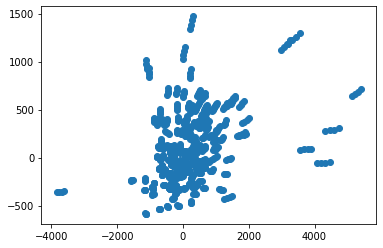

In [24]:
ytest_p, ytest = cnn.predict_x(ele_test)
plt.scatter(ytest, ytest_p)

In [25]:
cnn._cor_tf(ytest_p, ytest)

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.34737352, 0.34761643, 0.3456105 , 0.34507918], dtype=float32)>

In [26]:
cnn._cor_tf(ytest_pred_ls, ytest_ls)

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.27565733, 0.26802287, 0.26034147, 0.253008  ], dtype=float32)>